# Bias Evaluation : AIF360
***

Quantification of model bias in terms of fairness against protected groups before and after implementation of mitigation methods

## Terminology
***

***Favorable label:*** A label whose value corresponds to an outcome that provides an advantage to the recipient (such as receiving a loan, being hired for a job, not being arrested)

***Protected attribute:*** An attribute that partitions a population into groups whose outcomes should have parity (such as race, gender, caste, and religion)

***Privileged value (of a protected attribute):*** A protected attribute value indicating a group that has historically been at a systemic advantage

***Fairness metric:*** A quantification of unwanted bias in training data or models

***Discrimination/unwanted bias:*** Although bias can refer to any form of preference, fair or unfair, our focus is on undesirable bias or discrimination, which is when specific privileged groups are placed at a systematic advantage and specific unprivileged groups are placed at a systematic disadvantage. This relates to attributes such as race, gender, age, and sexual orientation.


## Structure of Evaluation & Intervention
***
<img src="images/aif360_pipeline.png" width="700" height="500" align="center"/>

### Three Perspectives of Fairness in ML algorithms
***

[linkedin article](https://www.linkedin.com/pulse/whats-new-deep-learning-research-reducing-bias-models-jesus-rodriguez/)

***1. Data vs Mode***

Fairness may be quantified in the training dataset or in the learned model

***2. Group vs Individual***

Group fairness partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across all groups. Individual fairness seeks for similar individuals to be treated similarly.


***3. WAE vs WYSIWYG (We are all equal vs What you see is what you get)***

WAE says that fairness is an equal distirbution of skills and opportunities among the participants in an ML task, attributing differences in outcome distributions to structural bias and not a difference in distribution to ability. WYSIWYG says that observations reflect ability with respect to a task.

> If the application follows the WAE worldview, then the demographic parity metrics should be used: disparate_impact and statistical_parity_difference.  If the application follows the WYSIWYG worldview, then the equality of odds metrics should be used: average_odds_difference and average_abs_odds_difference.  Other group fairness metrics (some are often labeled equality of opportunity) lie in-between the two worldviews and may be used appropriately: false_negative_rate_ratio, false_negative_rate_difference, false_positive_rate_ratio, false_positive_rate_difference, false_discovery_rate_ratio, false_discovery_rate_difference, false_omission_rate_ratio, false_omission_rate_difference, error_rate_ratio, and error_rate_difference. 

### 2. Evaluation of Bias in Models

<center><b>Average Odds Difference:</b> $ \tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}) + (TPR_{D = \text{privileged}} - TPR_{D = \text{unprivileged}}))\right] $ </center>


<br><br>


<center><b>Statistical Parity Difference:    </b>$ Pr(\hat{Y} = 1 | D = \text{unprivileged}) - Pr(\hat{Y} = 1 | D = \text{privileged}) $</center>


<br><br>


<center><b>Equal Opportunity Difference:    </b>$ TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}} $</center>


<br><br>


<center><b>Theil Index:    </b>$ \frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu}, \text{with} b_i = \hat{y}_i - y_i + 1 $</center>


<br><br>


<center><b>Disparate Impact:    </b> $ \frac{Pr(Y = 1 | D = \text{unprivileged})} {Pr(Y = 1 | D = \text{privileged})}$</center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
sns.set(context='talk', style='whitegrid')
from IPython.display import display, Markdown

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tensorflow import keras
from sklearn.metrics import RocCurveDisplay, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers  import Adam, Adagrad, SGD, RMSprop

# from aif360.sklearn.metrics import mdss_bias_scan, mdss_bias_score
import aif360
import utilities
import global_variables as gv
import fairness_helpers as fh

In [2]:
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference
from aif360.sklearn import metrics as mt
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### load data

In [4]:
X, X1 = fh.get_aif360_data()
X

1319-0.0  1408-0.0  1329-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                0.0       1.0       2.0   
1          1           0            1                0.0       3.0       2.0   
0          1           0            1                0.0       3.0       3.0   
1          1           0            1                3.0       3.0       3.0   
                                    0                0.0       3.0       2.0   
...                                                  ...       ...       ...   
                                    1                0.0       3.0       1.0   
0          1           0            1                0.0       1.0       1.0   
1          1           0            0                2.0       1.0       1.0   
0          1           0            1                3.0       3.0       1.0   
1          1           0            1                1.0       2.0       2.0   

                                                1448-0.0  1538-0.0  6142-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                3.0       2.0       1.0   
1          1           0            1                1.0       0.0       1.0   
0          1           0            1                2.0       1.0       2.0   
1          1           0            1                3.0       0.0       2.0   
                                    0                1.0       0.0       5.0   
...                                                  ...       ...       ...   
                                    1                1.0       2.0       1.0   
0          1           0            1                3.0       2.0       2.0   
1          1           0            0                2.0       2.0       1.0   
0          1           0            1                3.0       0.0       1.0   
1          1           0            1                1.0       0.0       1.0   

                                                2050-0.0  1508-0.0  1339-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                2.0       3.0       2.0   
1          1           0            1                1.0       2.0       2.0   
0          1           0            1                1.0       2.0       2.0   
1          1           0            1                1.0       2.0       2.0   
                                    0                2.0       2.0       2.0   
...                                                  ...       ...       ...   
                                    1                1.0       1.0       2.0   
0          1           0            1                1.0       1.0       1.0   
1          1           0            0                4.0       2.0       2.0   
0          1           0            1                1.0       2.0       2.0   
1          1           0            1                1.0       2.0       2.0   

                                                30710-0.0  1349-0.0  \
sex-binary race-binary race-grouped age-binary                        
0          1           0            1              0.3400       1.0   
1          1           0            1              3.9400       4.0   
0          1           0            1              0.5500       1.0   
1          1           0            1              0.4500       2.0   
                                    0              0.7500       2.0   
...                                                   ...       ...   
                                    1              1.4500       3.0   
0          1           0            1              2.7500       1.0   
1          1           0            0              0.8500       3.0   
0          1           0            1              3.5700       2.0   
1          1           0            1              2.9031       1.0   

 

In [5]:
gv.protected_attributes # sex, race, age

['31-0.0', '21000-0.0', '21003-0.0']

### Evaluate bias in original dataset: Disparate impact ratio

#### Interpretation:

<ul>
    <li> output range=[0,1]</li>
    <li> a higher value == more fair related to the given protected attribute</li>
    <li> x>0.8 is considered acceptable bias</li>

In [6]:
mt.disparate_impact_ratio(X['CVD'], prot_attr='sex-binary')

0.5661578163243346

In [7]:
mt.disparate_impact_ratio(X['CVD'], prot_attr='race-binary')

0.5438220418530659

In [8]:
mt.disparate_impact_ratio(X['CVD'], prot_attr='age-binary')

0.31036008621940697

> disparate impact ratios indicate that all three investigated protected attributes possess significant bias

### load model

In [9]:
model = keras.models.load_model('saved_models/mlp_binary_1.h5')
model.compile(loss='categorical_hinge',
              optimizer=SGD(learning_rate=0.0005),
              metrics=['acc',tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

#### get predictions

In [32]:
y = X1['CVD']
X_train, X_test, y_train, y_test = train_test_split(X1.drop('CVD', axis=1), y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [33]:
df_test = pd.concat([X_test, y_test], axis=1)

# split dataframe by sex
women_test = df_test[df_test['sex-binary']==0]
men_test = df_test[df_test['sex-binary']==1]

# split dataframe by race-binary
b_white_test = df_test[df_test['race-binary']==1]
b_non_white_test = df_test[df_test['race-binary']==0]

# split dataframe by race-grouped
white_test = df_test[df_test['race-grouped']==0]
black_test = df_test[df_test['race-grouped']==1]
asian_test = df_test[df_test['race-grouped']==2]
mixed_other_test = df_test[df_test['race-grouped']==3]

# split dataframe by age
young_test = df_test[df_test['age-binary']==0]
old_test = df_test[df_test['age-binary']==1]

In [35]:
# split into Input and target
X_all_test = df_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_all = df_test.loc[:,'CVD']

# sex
X_women = women_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_men = men_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_women = women_test.loc[:,'CVD']
y_men = men_test.loc[:,'CVD']

# race-binary
Xb_white = b_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
Xb_non_white = b_non_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
yb_white = b_white_test.loc[:,'CVD']
yb_non_white = b_non_white_test.loc[:,'CVD']

# race-grouped
X_white = white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_black = black_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_asian = asian_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_other = mixed_other_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_white = white_test.loc[:,'CVD']
y_black = black_test.loc[:,'CVD']
y_asian = asian_test.loc[:,'CVD']
y_other = mixed_other_test.loc[:,'CVD']

# age
X_young = young_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_old = old_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_young = young_test.loc[:,'CVD']
y_old = old_test.loc[:,'CVD']

In [36]:
y_prob_all = model.predict(X_all_test)

# predictions by sex
y_prob_women = model.predict(X_women)
y_prob_men = model.predict(X_men)

# predictions by race-binary
yb_prob_white = model.predict(Xb_white)
yb_prob_non_white = model.predict(Xb_non_white)

# predictions by race-grouped
y_prob_white = model.predict(X_white)
y_prob_black = model.predict(X_black)
y_prob_asian = model.predict(X_asian)
y_prob_other = model.predict(X_other)

# predictions by age
y_prob_young = model.predict(X_young)
y_prob_old = model.predict(X_old)

2389/2389 [==============================] - 14s 6ms/step


Threshold corresponding to Best balanced accuracy: 0.5186
Best balanced accuracy: 0.6768
Corresponding abs(1-disparate impact) value: 0.5741
Corresponding average odds difference value: -0.2787
Corresponding statistical parity difference value: -0.2767
Corresponding equal opportunity difference value: -0.3014
Corresponding Theil index value: 0.0892


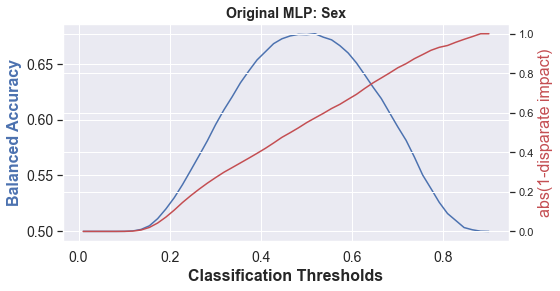

In [30]:
thresh_arr_best = fh.validate_visualize(pd.concat([women_test, men_test], axis=0), np.concatenate([y_prob_women, y_prob_men], axis=0), 'sex-binary')
plt.title('Original MLP: Sex', fontsize=14, fontweight = 'bold')
plt.savefig('charts/bias_eval/mlp_SEX_thresh_DI_og.png', bbox_inches='tight')

Threshold corresponding to Best balanced accuracy: 0.5186
Best balanced accuracy: 0.6768
Corresponding abs(1-disparate impact) value: 0.8788
Corresponding average odds difference value: -0.4027
Corresponding statistical parity difference value: -0.3690
Corresponding equal opportunity difference value: -0.4637
Corresponding Theil index value: 0.0892


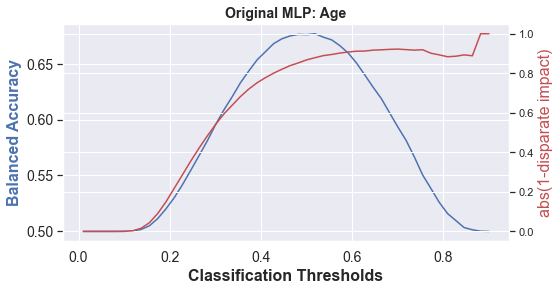

In [31]:
thresh_arr_best = fh.validate_visualize(pd.concat([young_test, old_test], axis=0), np.concatenate([y_prob_young, y_prob_old], axis=0), 'age-binary')
plt.title('Original MLP: Age', fontsize=14, fontweight = 'bold')
plt.savefig('charts/bias_eval/mlp__AGE_thresh_DI_og.png', bbox_inches='tight')

Threshold corresponding to Best balanced accuracy: 0.5186
Best balanced accuracy: 0.6768
Corresponding abs(1-disparate impact) value: 0.3584
Corresponding average odds difference value: -0.1164
Corresponding statistical parity difference value: -0.1211
Corresponding equal opportunity difference value: -0.1285
Corresponding Theil index value: 0.0892


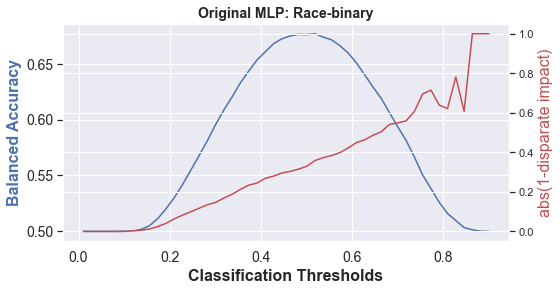

In [38]:
thresh_arr_best = fh.validate_visualize(pd.concat([b_white_test, b_non_white_test], axis=0), np.concatenate([yb_prob_white, yb_prob_non_white], axis=0), 'race-binary')
plt.title('Original MLP: Race-binary', fontsize=14, fontweight = 'bold')
plt.savefig('charts/bias_eval/mlp_RACE_BINARY_thresh_DI_og.png', bbox_inches='tight')

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Threshold corresponding to Best balanced accuracy: 0.4278
Best balanced accuracy: 0.6655
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0813


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Threshold corresponding to Best balanced accuracy: 0.5549
Best balanced accuracy: 0.6709
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0949
Threshold corresponding to Best balanced accuracy: 0.5186
Best balanced accuracy: 0.6757
Corresponding abs(1-disparate impact) value: 0.5754
Corresponding average odds difference value: -0.2823
Corresponding statistical parity difference value: -0.2831
Corresponding equal opportunity difference value: -0.3023
Corresponding Theil index value: 0.0899


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

Threshold corresponding to Best balanced accuracy: 0.4096
Best balanced accuracy: 0.6448
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0724


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

Threshold corresponding to Best balanced accuracy: 0.4822
Best balanced accuracy: 0.6834
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0751


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

Threshold corresponding to Best balanced accuracy: 0.3733
Best balanced accuracy: 0.6692
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0709


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Threshold corresponding to Best balanced accuracy: 0.3733
Best balanced accuracy: 0.6406
Corresponding abs(1-disparate impact) value: 0.2629
Corresponding average odds difference value: 0.0484
Corresponding statistical parity difference value: -0.0737
Corresponding equal opportunity difference value: 0.1806
Corresponding Theil index value: 0.0671


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Threshold corresponding to Best balanced accuracy: 0.5549
Best balanced accuracy: 0.6563
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.0994


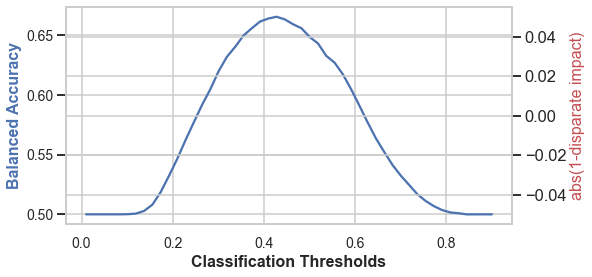

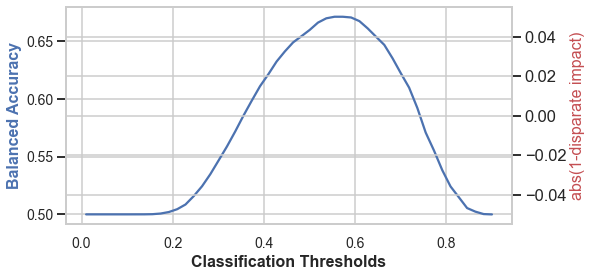

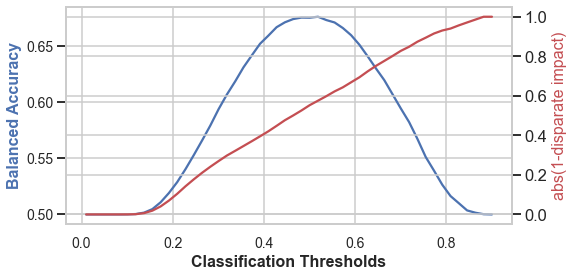

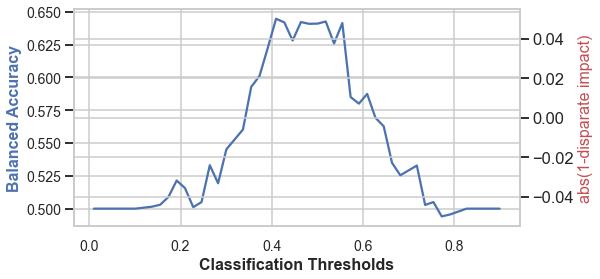

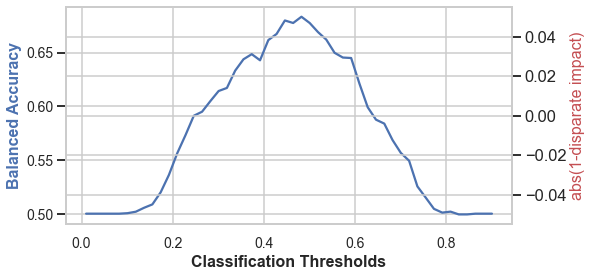

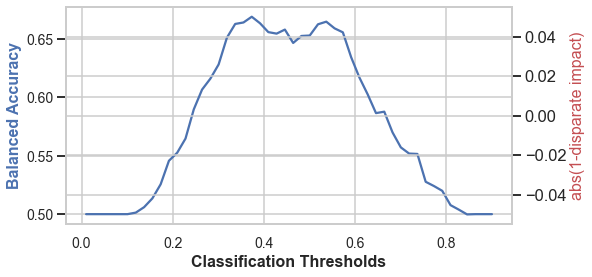

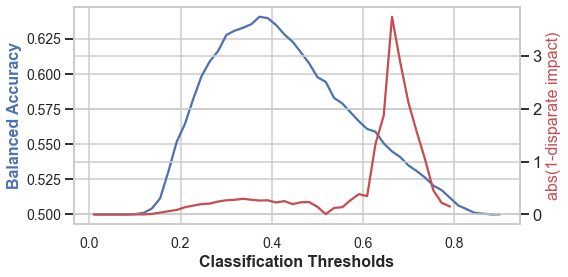

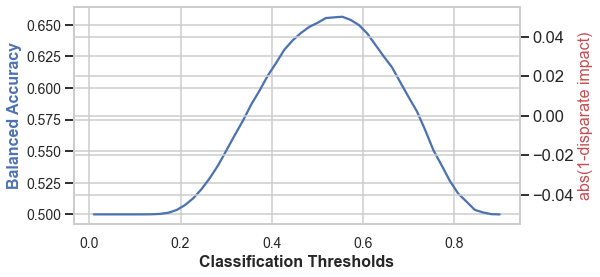

In [16]:
# get balanced accuracy 
thresholds = np.linspace(0.01, 0.9, 50)
all_dfs = [women_test, men_test, white_test, black_test, asian_test, mixed_other_test, young_test, old_test]
all_y_probs = [y_prob_women, y_prob_men, y_prob_white, y_prob_black, y_prob_asian, y_prob_other, y_prob_young, y_prob_old]
all_y_true = [y_women, y_men, y_white, y_black, y_asian, y_other, y_young, y_old]


# for threshold in thresholds:
for i, (df, pred) in enumerate(zip(all_dfs, all_y_probs)):
    if i<=2:
        attribute = 'sex-binary'
    elif 2<i<=6:
        attribute = 'race-grouped'
    elif i>6:
        attribute = 'age-binary'
        
    thresh_arr_best = fh.validate_visualize(df, pred, attribute)


## Determine privileged and unprivileged subgroups

In [17]:
## FEEDBACK: For me, should report classification metrics and the mean probability of positive outcomes for each subgroup
## and perform pairwise comparisons of means using Tukey’s range test, from there,  we can define which groups are privileged and unprivileged.

In [18]:
atts = fh.protected_attribute_names
CVD_counts = X1.CVD.value_counts()

positives_df = pd.DataFrame(columns=['protected_attribute', 'subgroup', 'mean positive probability'])

for att in atts:
    overall_prob = CVD_counts[1]/CVD_counts.sum()
    for i in range(len(X1[att].value_counts())):
        counts = X1['CVD'][X1[att]==i].value_counts()
        mean_val = counts[1]/counts.sum()
        df_new = pd.DataFrame({'protected_attribute':att, 'subgroup':i, 'mean positive probability':mean_val}, index=[0])
        positives_df = pd.concat([positives_df,df_new])

In [19]:
s_map = {0: 'female', 1:'male'}
age_map={0:'<50', 1:'>50'}
race1_map = {0:'Non-white', 1:'White'}
race_map ={0:'white', 1:'black',2:'asian', 3:'mixed/other'}
positives_df['subgroup'][positives_df['protected_attribute']=='sex-binary'] = positives_df['subgroup'][positives_df['protected_attribute']=='sex-binary'].map(s_map)
positives_df['subgroup'][positives_df['protected_attribute']=='race-binary'] = positives_df['subgroup'][positives_df['protected_attribute']=='race-binary'].map(race1_map)
positives_df['subgroup'][positives_df['protected_attribute']=='race-grouped'] = positives_df['subgroup'][positives_df['protected_attribute']=='race-grouped'].map(race_map)
positives_df['subgroup'][positives_df['protected_attribute']=='age-binary'] = positives_df['subgroup'][positives_df['protected_attribute']=='age-binary'].map(age_map)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

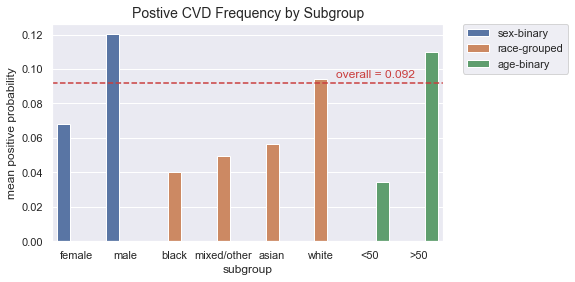

In [20]:
# define Seaborn color palette to use
sns.set_theme(style="darkgrid")

overall_prob = CVD_counts[1]/CVD_counts.sum()
positives_df.sort_values('protected_attribute')

for val in positives_df['protected_attribute'].unique():
    positives_df[positives_df['protected_attribute'] == val]=positives_df[positives_df['protected_attribute'] == val].sort_values('mean positive probability')
    
plt.figure(figsize=(7,4))
ax = sns.barplot(x="subgroup", y="mean positive probability", hue="protected_attribute", data=positives_df[positives_df['protected_attribute'] != 'race-binary'])
plt.title('Postive CVD Frequency by Subgroup', fontsize=14)
ax.axhline(overall_prob, ls='--', color='#CA3D3D')
ax.text(5.3,.095, "overall = 0.092", color='#CA3D3D')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('charts/bias_eval/cvd_freq.png', bbox_inches='tight')

## True Positive Rate (TPR) Disparity

We quantify the TPR disparity per subgroup/disease for sex and age. Instances of positive and negative disparities, which can denote bias for or against a subgroup indicates *favorable* or *unfavorable* subgroups.

In [21]:
def acc_vs_fairness(y_prob, y_true, attribute, threshold, metric):
    df_results = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy'])
    for threshold in test_thresholds:
        mat, sens,spec, acc = confusion_eval(model, X_test, y_test, threshold=threshold)

        df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc}, index=[0])
        df_results = pd.concat([df_results,df_new])
    

        
    return tpr_disparity

In [ ]:
test_thresholds=np.arange(0,1,0.05)

for thresh in test_thresholds:
    DI, bal_acc, recall = acc_vs_fairness()


## TPR Disparity in proportion to membership

Investigate the distribution of the positive patient proportion per subgroup and the effect on TPR disparitites

### Protected Attribute: Sex

In [ ]:
threshold = 0.8

In [ ]:
result = fh.get_fairness(X, 'sex-binary',threshold=threshold)
result

In [ ]:
result = fh.get_fairness(X, 'race-binary', threshold)
result

In [ ]:
result = fh.get_fairness(X, 'age-binary', threshold)
result

### Create AIF360 Datasets according to un/privileged groups

In [ ]:
dataset1 = StandardDataset(X1, 
                          label_name='CVD', 
                          favorable_classes=[1], 
                          protected_attribute_names=['sex-binary'], 
                          privileged_classes=[[1]])
dataset2 = StandardDataset(X1, 
                          label_name='CVD', 
                          favorable_classes=[1], 
                          protected_attribute_names=['race-binary'], 
                          privileged_classes=[[1]])
dataset3 = StandardDataset(X1, 
                          label_name='CVD', 
                          favorable_classes=[1], 
                          protected_attribute_names=['age-binary'], 
                          privileged_classes=[[1]])

In [ ]:
dataset1b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['sex-binary'])

dataset2b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['race-binary'])

dataset3b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['age-binary'])

In [ ]:
dataset1.labels

#### Sex

#### metrics for original training data

In [ ]:
privileged_groups, unprivileged_groups = fh.get_att_privilege_groups('sex-binary')

In [ ]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset1.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

# Get the dataset and split into train and test
dataset_orig_train1b, dataset_orig_vt1b = dataset1b.split([0.7], shuffle=True)
dataset_orig_valid1b, dataset_orig_test1b = dataset_orig_vt1b.split([0.5], shuffle=True)

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

In [ ]:
print('1-min(DI, 1/DI):', fh.get_disparity_index(metric_orig_train.disparate_impact()).round(3))

#### Race

In [ ]:
privileged_groups2, unprivileged_groups2 = fh.get_att_privilege_groups('race-binary')

# Get the dataset and split into train and test
dataset_orig_train2, dataset_orig_vt2 = dataset2.split([0.7], shuffle=True)
dataset_orig_valid2, dataset_orig_test2 = dataset_orig_vt2.split([0.5], shuffle=True)

In [ ]:
metric_orig_train2 = BinaryLabelDatasetMetric(dataset_orig_train2, 
                             unprivileged_groups=unprivileged_groups2,
                             privileged_groups=privileged_groups2)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train2.mean_difference())

metric_orig_valid2 = BinaryLabelDatasetMetric(dataset_orig_valid2, 
                             unprivileged_groups=unprivileged_groups2,
                             privileged_groups=privileged_groups2)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid2.mean_difference())

metric_orig_test2 = BinaryLabelDatasetMetric(dataset_orig_test2, 
                             unprivileged_groups=unprivileged_groups2,
                             privileged_groups=privileged_groups2)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test2.mean_difference())

In [ ]:
print('1-min(DI, 1/DI):', fh.get_disparity_index(metric_orig_train2.disparate_impact()).round(3))

#### Age

In [ ]:
privileged_groups3, unprivileged_groups3 = fh.get_att_privilege_groups('age-binary')

# Get the dataset and split into train and test
dataset_orig_train3, dataset_orig_vt3 = dataset3.split([0.7], shuffle=True)
dataset_orig_valid3, dataset_orig_test3 = dataset_orig_vt3.split([0.5], shuffle=True)

In [ ]:
metric_orig_train3 = BinaryLabelDatasetMetric(dataset_orig_train3, 
                             unprivileged_groups=unprivileged_groups3,
                             privileged_groups=privileged_groups3)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train3.mean_difference())

metric_orig_valid3 = BinaryLabelDatasetMetric(dataset_orig_valid3, 
                             unprivileged_groups=unprivileged_groups3,
                             privileged_groups=privileged_groups3)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid3.mean_difference())

metric_orig_test3 = BinaryLabelDatasetMetric(dataset_orig_test3, 
                             unprivileged_groups=unprivileged_groups3,
                             privileged_groups=privileged_groups3)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test3.mean_difference())

In [ ]:
print('1-min(DI, 1/DI):', fh.get_disparity_index(metric_orig_train3.disparate_impact()).round(3))

In [ ]:
metric_orig_train3.theil_index()